# Necessary Imports:

In [2]:
%pip install scikit-learn
%pip install matplotlib
%pip install pandas
%pip install wordcloud
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import split
from pyspark.sql.functions import when
from pyspark.sql.functions import udf, col, lower, regexp_replace
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, split, col
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd 
import seaborn as sns 

In the above code we're just installing necessary modules and importing libararies. 

# Spark Session

In [4]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("SparkApp") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/05/18 09:22:58 WARN Utils: Your hostname, Nayan-PC resolves to a loopback address: 127.0.1.1; using 172.21.159.204 instead (on interface eth0)
24/05/18 09:22:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/18 09:22:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Path

In [5]:
# Set path
path = "hdfs://localhost:9000/gps_sentiment/googleplaystore_user_reviews.csv"
df = spark.read.csv(path, header=True, inferSchema=True)

## Dataframe

In [6]:
df.show()

+--------------------+--------------------+--------------------+-------------------+----------------------+
|                 App|   Translated_Review|           Sentiment| Sentiment_Polarity|Sentiment_Subjectivity|
+--------------------+--------------------+--------------------+-------------------+----------------------+
|10 Best Foods for...|"I like eat delic...| also ""Best Befo...|           Positive|                   1.0|
|10 Best Foods for...|This help eating ...|            Positive|               0.25|   0.28846153846153844|
|10 Best Foods for...|                 nan|                 nan|                nan|                   nan|
|10 Best Foods for...|Works great espec...|            Positive|                0.4|                 0.875|
|10 Best Foods for...|        Best idea us|            Positive|                1.0|                   0.3|
|10 Best Foods for...|            Best way|            Positive|                1.0|                   0.3|
|10 Best Foods for...|      

In [7]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Translated_Review: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- Sentiment_Polarity: string (nullable = true)
 |-- Sentiment_Subjectivity: string (nullable = true)



# Data Pre-Processing

### Dropping irrelevant columns

In [8]:
unwanted_columns = ["App", "Sentiment_Polarity", "Sentiment_Subjectivity"]  
df = df.drop(*unwanted_columns)

In [9]:
df.show()

+--------------------+--------------------+
|   Translated_Review|           Sentiment|
+--------------------+--------------------+
|"I like eat delic...| also ""Best Befo...|
|This help eating ...|            Positive|
|                 nan|                 nan|
|Works great espec...|            Positive|
|        Best idea us|            Positive|
|            Best way|            Positive|
|             Amazing|            Positive|
|                 nan|                 nan|
|Looking forward app,|             Neutral|
|It helpful site !...|             Neutral|
|           good you.|            Positive|
|Useful informatio...|            Positive|
|Thank you! Great ...|            Positive|
|Greatest ever Com...|            Positive|
|Good health.........|            Positive|
|                 nan|                 nan|
|Health It's impor...|            Positive|
|Mrs sunita bhati ...|            Positive|
|Very Useful in di...|            Positive|
|  One greatest apps.|          

### Checking for null values

In [10]:
null_counts = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns]) \
                .groupBy().sum()
null_counts.show()

+----------------------+--------------+
|sum(Translated_Review)|sum(Sentiment)|
+----------------------+--------------+
|                     5|             0|
+----------------------+--------------+



In [11]:
df = df.dropna(subset=["Sentiment"])
df = df.dropna(subset=["Translated_Review"])

### Checking for duplicate values

In [12]:
num_duplicates = df.count() - df.dropDuplicates().count()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 36296


In [13]:
df = df.dropDuplicates()

### Creating a text-cleaning pipeline

In [14]:
# Remove URLs from text
def remove_urls(text):
    return re.sub(r'http\S+', ' ', text)

# Remove unwanted characters
def remove_unwanted_characters(text):
    return re.sub(r'[^a-zA-Z\s]', ' ', text)

# Tokenize text
def tokenize_text(text):
    return word_tokenize(text)

# Remove stopwords
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

In [15]:
def text_cleaning_pipeline(df, input_column, output_column):
    """
    This function performs basic text cleaning steps including converting text to lowercase,
    removing URLs, emojis, unwanted characters, stopwords.
    It creates a new column with the cleaned text.
    """
    # Convert the input column to lowercase
    df = df.withColumn(input_column, lower(col(input_column)))

    # Remove URLs
    df = df.withColumn(output_column, regexp_replace(col(input_column), r'http\S+', ' '))

    # Remove all other unwanted characters
    remove_unwanted_characters_udf = udf(remove_unwanted_characters)
    df = df.withColumn(output_column, remove_unwanted_characters_udf(col(output_column)))

    # Tokenize text
    tokenize_text_udf = udf(tokenize_text)
    df = df.withColumn(output_column, tokenize_text_udf(col(output_column)))

    # Remove stopwords
    remove_stopwords_udf = udf(remove_stopwords)
    df = df.withColumn(output_column, remove_stopwords_udf(col(output_column)))

    # Convert the tokenized text into an array of strings
    df = df.withColumn(output_column, split(col(output_column), ' '))

    return df

In [17]:
# Apply the function
df = text_cleaning_pipeline(df, "Translated_Review", "Cleaned_Review")

### Filtering column 'Sentiment'

In [18]:
df = df.filter((col('Sentiment') == 'Positive') | (col('Sentiment') == 'Negative'))

In [ ]:
df.show()

+--------------------+---------+--------------------+
|   Translated_Review|Sentiment|      Cleaned_Review|
+--------------------+---------+--------------------+
|         easy access| Positive|   [[easy,, access]]|
|           nice game| Positive|     [[nice,, game]]|
|"always challengi...| Positive|[[always,, challe...|
|good help grow ea...| Positive|[[good,, help,, g...|
|great, i wish opt...| Positive|[[great,, wish,, ...|
|    this soccer good| Positive|   [[soccer,, good]]|
|this app,is reall...| Positive|[[app,, really,, ...|
|my daughter kids ...| Positive|[[daughter,, kids...|
|why disable group...| Positive|[[disable,, group...|
|for me best appli...| Positive|[[best,, applicat...|
|bad after uploadi...| Negative|[[bad,, uploading...|
|it's great app. t...| Positive|[[great,, app,, d...|
|             it's ok| Positive|              [[ok]]|
|         worst ever.| Negative|    [[worst,, ever]]|
|it's ok launch fi...| Positive|[[ok,, launch,, f...|
|it's cool, would ...| Posit

### Visualization of Sentiments

In [ ]:
distinct_sentiments = df.groupBy("Sentiment").count()
distinct_sentiments.show()

+---------+-----+
|Sentiment|count|
+---------+-----+
| Positive|17286|
| Negative| 6117|
+---------+-----+



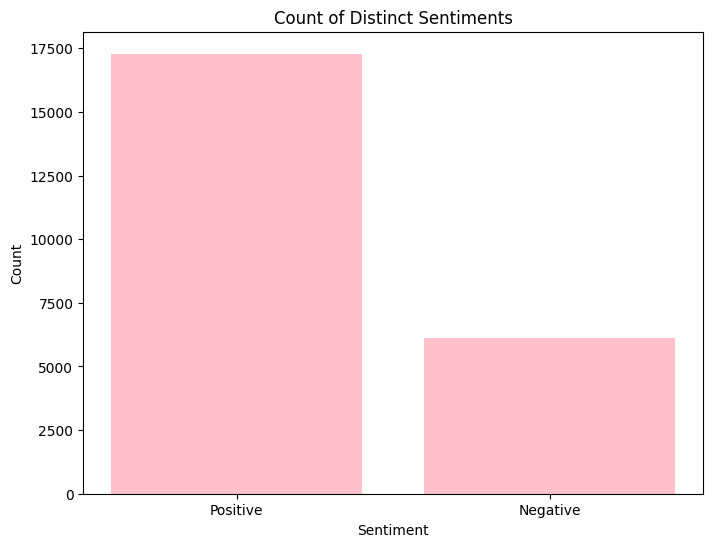

In [ ]:
# Convert DataFrame to Pandas DataFrame for plotting
distinct_sentiments_pd = distinct_sentiments.toPandas()

# Plot bar graph
plt.figure(figsize=(8, 6))
plt.bar(distinct_sentiments_pd["Sentiment"], distinct_sentiments_pd["count"], color='pink')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Count of Distinct Sentiments')
plt.show()

### WordCloud Plot of Tokenized Texts

In [ ]:
# Filtering postive and negative words
positive_words = df.filter(col("Sentiment") == "Positive").select(explode("Cleaned_Review").alias("word"))
negative_words = df.filter(col("Sentiment") == "Negative").select(explode("Cleaned_Review").alias("word"))

# Function that generates wordcloud
def generate_wordcloud(words_df, sentiment):
    # Convert words to word counts
    word_counts = words_df.groupBy("word").count().orderBy("count", ascending=False)
    
    # Convert to Pandas DataFrame
    word_counts_pd = word_counts.toPandas()
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(word_counts_pd["word"]))
    
    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud ({sentiment})")
    plt.show()

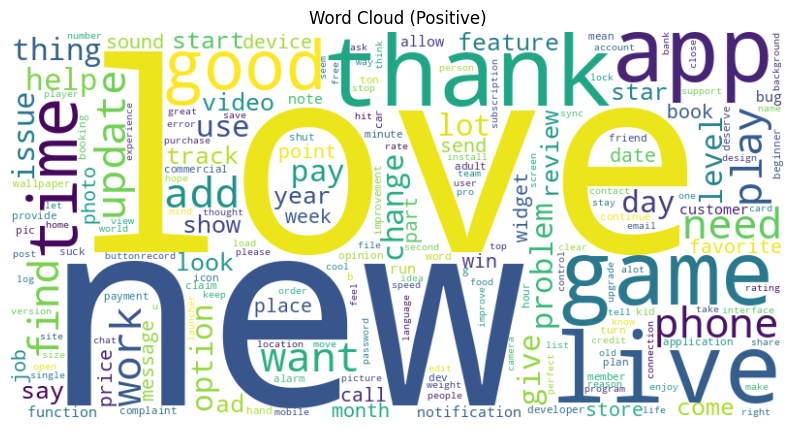

In [ ]:
# Generate word clouds for positive words
generate_wordcloud(positive_words, "Positive")

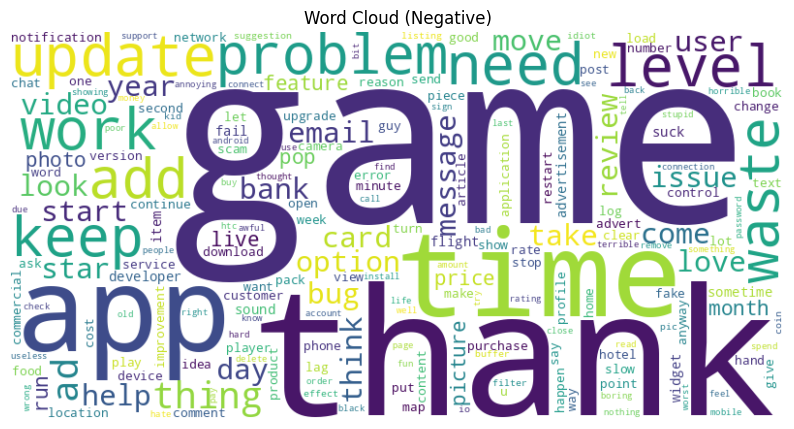

In [ ]:
# Generate word clouds for negative words
generate_wordcloud(negative_words, "Negative")

# Model Building 

### Categorical Values to Numberical Values
Postive: 0.0 <br>
Negative: 1.0

In [ ]:
# Convert the 'Sentiment' column to numerical labels
indexer = StringIndexer(inputCol="Sentiment", outputCol="label")

# Fit the StringIndexer to the data
string_indexer_model = indexer.fit(df)

# Transform the DataFrame to add the encoded column
df_encoded = string_indexer_model.transform(df)

# Show the DataFrame with the encoded column
df_encoded.select("Translated_Review", "Sentiment", "label").show()

+--------------------+---------+-----+
|   Translated_Review|Sentiment|label|
+--------------------+---------+-----+
|         easy access| Positive|  0.0|
|           nice game| Positive|  0.0|
|"always challengi...| Positive|  0.0|
|good help grow ea...| Positive|  0.0|
|great, i wish opt...| Positive|  0.0|
|    this soccer good| Positive|  0.0|
|this app,is reall...| Positive|  0.0|
|my daughter kids ...| Positive|  0.0|
|why disable group...| Positive|  0.0|
|for me best appli...| Positive|  0.0|
|bad after uploadi...| Negative|  1.0|
|it's great app. t...| Positive|  0.0|
|             it's ok| Positive|  0.0|
|         worst ever.| Negative|  1.0|
|it's ok launch fi...| Positive|  0.0|
|it's cool, would ...| Positive|  0.0|
|simple nice varie...| Positive|  0.0|
|you are angry, gu...| Negative|  1.0|
|good girls people...| Positive|  0.0|
|aside loads ads, ...| Positive|  0.0|
+--------------------+---------+-----+
only showing top 20 rows



### Text Documents to Vectors

In [ ]:
# Convert a collection of text documents to vectors of token counts
vectorizer = CountVectorizer(inputCol="Cleaned_Review", outputCol="features")

### Build a Logistic Regression model

In [ ]:
# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

### Create a sequence of stages

In [ ]:
# Pipeline
pipeline = Pipeline(stages=[indexer, vectorizer, lr])

### Splitting the data
Train: 80 <br>
Test: 20

In [ ]:
# Split the data into training and testing sets 
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

### Model Training

In [ ]:
# Train the model
model = pipeline.fit(train_data)

24/05/18 09:15:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


# Model Evaluation

### Accuracy

In [ ]:
# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

Accuracy: 0.8516344099212478


### Predictions

In [ ]:
# Make predictions on the test data
predictions = model.transform(test_data)

# Convert numerical predictions back to sentiment labels
predictions = predictions.withColumn("Predicted_Sentiment", when(col("prediction") == 0, "Positive").otherwise("Negative"))

# Display the predictions in the desired format
predictions.select("Predicted_Sentiment","Translated_Review","Cleaned_Review").show(truncate=False)

+-------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Classification Report

In [ ]:
# Convert to Pandas DataFrame
predictions_pd = predictions.select("label", "prediction").toPandas()

# Convert labels to integers
predictions_pd["label"] = predictions_pd["label"].astype(int)

# Generate classification report
print(classification_report(predictions_pd["label"], predictions_pd["prediction"]))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87      3365
           1       0.61      0.71      0.66      1187

    accuracy                           0.81      4552
   macro avg       0.75      0.78      0.76      4552
weighted avg       0.82      0.81      0.81      4552



### Confusion Matrix

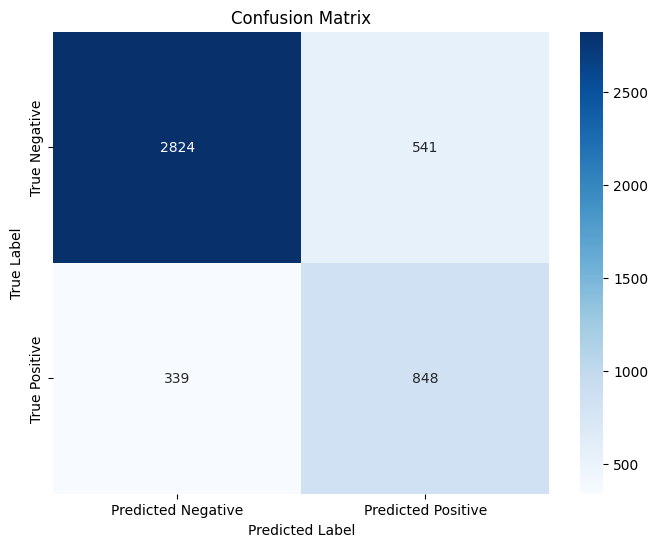

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])

# Convert to DataFrame 
conf_matrix_df = pd.DataFrame(conf_matrix, index=["True Negative", "True Positive"], columns=["Predicted Negative", "Predicted Positive"])

# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()